<a href="https://colab.research.google.com/github/edgeofchaos42/ComplexityExplorer/blob/main/Session_19_Batch_Runner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1- Review lesson 18 and intro

Script Notes: 

In lesson 18 we collected agent trading partners and created the trade network, which we then ran some network stastistics against. Yet, ABMs often need sensitivity analysis and so we want to do parameters sweeps to see results of different parameters. For this Mesa has batch_runner.      

*Review each class and model set up*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try: 
  import mesa
except: 
  !pip install mesa --quiet
  import mesa
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
#part 3
import networkx as nx


from statistics import mean, stdev
from scipy.stats import gmean



%matplotlib inline 

     |████████████████████████████████| 2.5 MB 5.1 MB/s 
     |████████████████████████████████| 66 kB 4.4 MB/s 


In [ ]:
def get_distance(pos_1, pos_2):
    """Calculate Euclidean distance between two positions.
    Args:
        pos_1, pos_2: Coordinate tuples for both points.
    
    used in trader.move()
    """
    x1, y1 = pos_1
    x2, y2 = pos_2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def get_trade(agent):
  if type(agent) == Trader:
    return agent.trade_partners
  else: return None


In [ ]:
class Sugar(mesa.Agent):
    """
    Sugar is a FSM that
    - contains an amount of sugar
    - grows 1 amount of sugar at each turn (rule G1).
    """
    
    
    def __init__(self, unique_id, model, pos, max_sugar): 
      super().__init__(unique_id, model) #part 3
      self.pos = pos
      self.amount = max_sugar
      self.max_sugar = max_sugar

    def step(self): 
      self.amount = min([self.max_sugar,self.amount+1])
      
      

In [ ]:
class Spice(mesa.Agent):
    """
    Spice is a FSM that
    - contains an amount of spice
    - grows 1 amount of spice at each turn. (rule G1)
    """

    def __init__(self, unique_id, model, pos, max_spice): 
        super().__init__(unique_id, model) 
        self.pos = pos
        self.amount = max_spice
        self.max_spice = max_spice

    def step(self): #Part 1
      self.amount = min([self.max_spice,self.amount+1])
       

## Trader Agent

In [ ]:
class Trader(mesa.Agent):
    """
    TraderAgent is a 
    - has a metabolism for sugar and spice
    - harvest and trades sugar and spice to survive and thrive
    """

    def __init__(self, unique_id, model,pos,moore=False, sugar=0, 
                 spice=0, metabolism_sugar=0, metabolism_spice=0,
                 vision=0): 
      super().__init__(unique_id, model)
      self.pos = pos 
      self.moore = False 
      self.sugar = sugar 
      self.spice = spice 
      self.metabolism_sugar=metabolism_sugar 
      self.metabolism_spice=metabolism_spice 
      self.vision = vision 
      self.prices = []
      self.trade_partners = []

  
    def get_sugar(self, pos): #part 2
      '''
      used in:
         get_sugar_amount()
         eat()

      '''
      this_cell = self.model.grid.get_cell_list_contents(pos)
      for agent in this_cell:
          if type(agent) is Sugar:
              return agent
      return None
    
    
    def get_sugar_amount(self, pos):
      '''
      used in move()
      '''
      
      sugar_patch = self.get_sugar(pos)
      if sugar_patch:
          return sugar_patch.amount
      return 0
    
    
    def get_spice(self, pos):
      '''
      used in get_spice_amount
      '''
      this_cell = self.model.grid.get_cell_list_contents(pos)
      for agent in this_cell:
          if type(agent) is Spice:
              return agent
      return None
        
    
    def get_spice_amount(self, pos):
        '''
        used in move()
        '''
        spice_patch = self.get_spice(pos)
        if spice_patch: 
          return spice_patch.amount
        return 0
  
    def get_trader(self, pos):
      '''
      used in trade_with neighbors()
      '''
      this_cell =self.model.grid.get_cell_list_contents(pos)

      for agent in this_cell: 
        if isinstance(agent, Trader):
          return agent
    
    
    def is_occupied(self, pos): 
      '''
      Helper function for move()
      '''
      
      this_cell = self.model.grid.get_cell_list_contents(pos)
      for a in this_cell:
          if isinstance(a, Trader) and a.pos != self.pos:
              return True
      return False
       
    def calculate_welfare(self, sugar, spice): #This will be built to be like the example later with none, but right now it wouldn't make any sense
      '''
      Helper function for:
      move()
      trade()

      '''

      #calculate total resources
      m_total = self.metabolism_sugar + self.metabolism_spice
      #Cobb-Douglas functional form
      return sugar** (self.metabolism_sugar/m_total) * spice ** (
          self.metabolism_spice/m_total)
      
    def is_starved(self): 
      '''
      helper function for maybe_die()
      '''

      return (self.sugar <= 0) or (self.spice <=0)

    def calculate_MRS(self): 
      '''
      used in trade()
      '''

      return (self.spice/self.metabolism_spice) / (self.sugar/self.metabolism_sugar)
    
    def calculate_sell_spice_amount(self, price):
      '''
      Helper function for maybe_sell_spice() which is called from trade()
      '''
      if price >= 1:
          sugar = 1
          spice = int(price)
      else:
          sugar = int(1 / price)
          spice = 1
      return sugar, spice

    def sell_spice(self, other, sugar, spice):
      '''
      used in maybe_sell_spice
      :param: Agent object
      :param: int sugar to be exchanged
      :param: int spice to be exchanged
      '''

      self.sugar += sugar
      other.sugar -= sugar
      self.spice -= spice
      other.spice += spice
  
    
    def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
      '''
      helper function for trade()
      '''
      sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)

      # Preparing the new sugar spice amount -- what if the exchange were to occur.
      self_sugar = self.sugar + sugar_exchanged
      other_sugar = other.sugar - sugar_exchanged
      self_spice = self.spice - spice_exchanged
      other_spice = other.spice + spice_exchanged

      #Double Check to see if agents have resources

      if (
          (self_sugar <=0)
       or (other_sugar <= 0)
       or (self_spice <= 0)
       or (other_spice <= 0)):
        return False

      #trade crtieria 1 are both agents better off?
      both_agents_better_off = (
          welfare_self < self.calculate_welfare(self_sugar, self_spice) and 
          (welfare_other < other.calculate_welfare(other_sugar, other_spice)))
      
      #trade criteria 2 is their mrs crossing
      mrs_not_crossing = self.calculate_MRS() > other.calculate_MRS()

      if not (both_agents_better_off and mrs_not_crossing):
            return False

      #add sell spice
      self.sell_spice(other, sugar_exchanged, spice_exchanged)

      return True
       

    
    def trade(self, other):
      '''
      used in trade_with_neighbors()
      '''
      #Part 0
      #sanity check to verify code is working the way we think
      assert self.sugar > 0
      assert self.spice > 0
      assert other.sugar > 0 
      assert other.spice > 0 

      mrs_self = self.calculate_MRS()
      mrs_other = other.calculate_MRS()
      #part 1: 
      welfare_self = self.calculate_welfare(self.sugar, self.spice)
      welfare_other = other.calculate_welfare(other.sugar, other.spice)

      if math.isclose(mrs_self, mrs_other, rel_tol=1e-09): 
        return 

      price = math.sqrt(mrs_self*mrs_other)

      if mrs_self > mrs_other: 
        #self is a sugar buyer
        sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)
        #part 2
        if not sold: 
          return
      else: 
        #self is a spice buyer
        sold = other.maybe_sell_spice(self, price, welfare_other, welfare_self)
        if not sold: 
          return
      
      #part 3
      self.prices.append(price)
      if other.unique_id not in self.trade_partners: 
        self.trade_partners.append(other.unique_id)

      #continue trading
      self.trade(other)




    ###########################################################################
    #                                                                         #
    #                            MAIN FUNCTIONS                               #
    #                                                                         #
    ###########################################################################

    def move(self): 
           
      # 1. Get neighbors within vision

      neighbors = [i 
                   for i in self.model.grid.get_neighborhood(
                       self.pos, self.moore,True, self.vision
                       )
                   if not self.is_occupied(i)
      ]

      # 2. Find the patch which produce the maximum welfare. 

      welfares = [
            self.calculate_welfare(
                self.sugar + self.get_sugar_amount(pos),
                self.spice + self.get_spice_amount(pos),
            )
            for pos in neighbors] #part 2

      #find the highest welfare in the cell 
      max_welfare = max(welfares)
      #get the index of maximal welfare cells
      candidate_indices = [i for i in range(len(welfares))
                             if math.isclose(welfares[i], max_welfare,
                                             rel_tol=1e-09)]
      #convert index to positions of those cells
      candidates = [neighbors[i] for i in candidate_indices]
     
      
      # 3. Find the nearest patch among the candidate.
      min_dist = min([get_distance(self.pos, pos) for pos in candidates])
      final_candidates = [pos for pos in candidates if math.isclose(get_distance(self.pos, pos),
                                                                   min_dist, rel_tol=1e-09)]
      self.random.shuffle(final_candidates)

      # 4. Move agent.
      self.model.grid.move_agent(self, final_candidates[0])



    def eat(self):
      #get sugar
      sugar_patch = self.get_sugar(self.pos)

      if sugar_patch:
        self.sugar = (self.sugar + sugar_patch.amount) - self.metabolism_sugar
        sugar_patch.amount = 0
        #print(self.sugar, sugar_patch.amount)
      
      #get_spice part 2
      spice_patch = self.get_spice(self.pos)
      #print(spice_patch)
      if spice_patch: 
        self.spice = (self.spice + spice_patch.amount) - self.metabolism_spice
        spice_patch.amount = 0
        #print(self.spice, spice_patch.amount)

    def maybe_die(self): 

      if self.is_starved(): 
        self.model.grid.remove_agent(self) 
        self.model.schedule.remove(self)
          
    def trade_with_neighbors(self):
      
      neighbor_agents =[self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
          self.pos, self.moore, False, radius=self.vision) if self.is_occupied(pos)]
        
      if len(neighbor_agents) == 0:
            #part 4
            return [], []
      
      for a in neighbor_agents: 
        if a: 
          self.trade(a)
      #
      prices = [p for p in self.prices if p ]
      trader_partners = [t for t in self.trade_partners if t]
      self.prices = []
      self.trade_partners = []
      #print(prices, trader_partners)
      return prices, trader_partners

## Main

In [ ]:
class SugarscapeG1mt(mesa.Model):

  def __init__(self, width=50, height=50, initial_population=200,
               endowment_min =25, endowment_max =50, metabolism_min = 1,
                 metabolism_max = 5, vision_min = 1, vision_max =5, seed=96): 
    
    self.width = width
    self.height = height
    self.initial_population =initial_population 
    self.endowment_min = endowment_min 
    self.endowment_max = endowment_max 
    self.metabolism_min = metabolism_min
    self.metabolism_max = metabolism_max
    self.vision_min = vision_min
    self.vision_max = vision_max


    self.schedule = mesa.time.RandomActivationByType(self)
    self.grid = mesa.space.MultiGrid(self.width, self.height, torus=True)
    #We need to do a release
    self.running=True
    
    
    #####################################################################
    #####################################################################
    #

    #part 1
    self.datacollector = mesa.DataCollector(
        model_reporters= {"Trader": lambda m: m.schedule.get_type_count(Trader),
         "Trade volume": lambda m: sum(len(a.trade_partners)
         for a in m.schedule.agents_by_type[Trader].values()),
         "Price": lambda m: list(itertools.chain.from_iterable([a.prices for a in m.schedule.agents_by_type[Trader].values()]))},
         )

    sugar_distribution = np.genfromtxt("/content/drive/MyDrive/sugar-map.txt") 
    spice_distribution = spice = np.flip(sugar_distribution,1)
    
    #ensure unique id
    agent_id = 0
    for _, x, y in self.grid.coord_iter(): 
      max_sugar = sugar_distribution[x,y]
      if max_sugar > 0: 
        sugar = Sugar(agent_id, self, (x,y),max_sugar)
        self.grid.place_agent(sugar, (x, y))
        #Place Agent
        self.schedule.add(sugar) 
        agent_id += 1

      max_spice = spice_distribution[x,y]
      if max_spice > 0: 
        spice = Spice(agent_id, self, (x,y), max_spice)
        self.grid.place_agent(spice,(x,y))
        self.schedule.add(spice)
        agent_id += 1
         
    
    for i in range(self.initial_population):
      #get agent position
      x = self.random.randrange(self.width) 
      y = self.random.randrange(self.height) 
      # See GAS page 108 for parameters initialization.
      # Each agent is endowed by a random amount of sugar and spice
      sugar = self.random.randint(self.endowment_min, self.endowment_max) 
      spice = self.random.randint(self.endowment_min, self.endowment_max) 
      #add metabolism also on page #108
      metabolism_sugar = self.random.uniform(self.metabolism_min, self.metabolism_max+1)
      metabolism_spice = self.random.uniform(self.metabolism_min, self.metabolism_max+1)
      #add vision
      vision =int(self.random.uniform(self.vision_min, self.vision_max+1))
      trader = Trader(
                agent_id,
                self,
                (x, y),
                False,
                sugar,
                spice,
                metabolism_sugar,
                metabolism_spice,
                vision,
            )
      self.grid.place_agent(trader, (x, y))
      self.schedule.add(trader)
      agent_id += 1
      
  def randomize_traders(self): 
    """
    Helper function for step()

    updates list of agents used in step function
    """
    
    Traders = self.schedule.agents_by_type[Trader].values()
    Trader_shuffle = list(Traders)
    self.random.shuffle(Trader_shuffle)

    return Trader_shuffle
  
  
  def step(self): 
    
    for sugar in self.schedule.agents_by_type[Sugar].values(): 
      sugar.step()
    
    for spice in self.schedule.agents_by_type[Spice].values(): 
      spice.step()
        
    Trader_shuffle = self.randomize_traders()
    
    for agent in Trader_shuffle: 
      agent.move() 
      agent.eat() 
      agent.maybe_die() 

    Trader_shuffle = self.randomize_traders()
        
    for agent in Trader_shuffle: 
      agent.prices, agent.trade_partners = agent.trade_with_neighbors()
    
    self.schedule.time +=1
    self.schedule.steps += 1
    
    #part 2 ###############################################
    #collect at each step
    self.datacollector.collect(self)
 
  def run_model(self, step_count=1000):
    
    for i in range(step_count):
      self.step()

## Model Run 


In [ ]:
model = SugarscapeG1mt()
model.run_model(step_count=100) 

NameError: ignored

## Batch Run

Batch runner allows for sensitivity analysis, but we can't go too crazy as we have limited RAM available and want to stay in Google's free enviroment. So, we are going to stop collecting the trade partners as that requires a lot of memory and we are going to just alter the vision. So to execute batchrunner, we create a dictinary of the paramters and an iterable of those paramters we want to vary. So in this case just to show the capability we will add width and height as an int (not really needed ut just to show) and then alter vision with min and max and as you can see we can pass in a ptyhon iterable like range or write out our own list. Batch runner will then do every combination of this so 1, 10, 5,5 etc. Then we pass our parameters into the model. Batch Runner has numerous arguments and we will go through a few of those but the full list can be easily seen in the [intro tutorial](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html#batch-run). We pass the model object, the parameters, and then there is a key word argument iterations how many times to run each model so one can understand the range of results one may get.As we see use a random seed we will just keep it at 1, you can also use multiprocessing, but it seems Colab locks that down so even if you put in additional processors it runs as fast as if you were running 1. then we can also display provess, if you are using mutliple proccess this will give you sporadic results as the various processors send the results back to the processor being displayed. 

In [ ]:
params = {"width": 50, "height": 50, 
          "vision_min": range(1,3), 
          "vision_max":[5,8]
          }


results = mesa.batch_run(
    SugarscapeG1mt,
    parameters=params,
    iterations=1,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

4it [03:19, 49.83s/it]


# Results Batch Runner

Now that we have our results we can eplore them with Pandas and our dataframe. For brevity sake we will just look at the average price over time steps as seen on page 109 in Growing artificial soscieties. The key behavior we are looking for is are the prices trending toward an equilibrium of 1. 

First we load then we take the mean of the price column then we can plot. Then we can filter to get specific results so let's do that and we can plot it and we can plot the trade volume. 

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df   

,RunId,iteration,Step,width,height,vision_min,vision_max,Trader,Trade volume,Price
0,0,0,0,50,50,1,5,200,107,"[1.1279808251112535, 0.7484427583754757, 0.744..."
1,0,0,1,50,50,1,5,200,136,"[1.1279808251112535, 0.7484427583754757, 0.744..."
2,0,0,2,50,50,1,5,200,164,"[1.1279808251112535, 0.7484427583754757, 0.744..."
3,0,0,3,50,50,1,5,200,193,"[1.1279808251112535, 0.7484427583754757, 0.744..."
4,0,0,4,50,50,1,5,200,231,"[1.1279808251112535, 0.7484427583754757, 0.744..."
...,...,...,...,...,...,...,...,...,...,...
3999,3,0,996,50,50,2,8,47,944,"[1.0050687765435302, 0.9427931784087875, 0.997..."
4000,3,0,997,50,50,2,8,47,945,"[1.0050687765435302, 0.9427931784087875, 0.997..."
4001,3,0,998,50,50,2,8,47,945,"[1.0050687765435302, 0.9427931784087875, 0.997..."
4002,3,0,999,50,50,2,8,47,946,"[1.0050687765435302, 0.9427931784087875, 0.997..."


In [ ]:
results_df["Average Price"] = results_df["Price"].apply(gmean)
results_df

,RunId,iteration,Step,width,height,vision_min,vision_max,Trader,Trade volume,Price,Average Price
0,0,0,0,50,50,1,5,200,107,"[1.1279808251112535, 0.7484427583754757, 0.744...",1.071518
1,0,0,1,50,50,1,5,200,136,"[1.1279808251112535, 0.7484427583754757, 0.744...",1.062099
2,0,0,2,50,50,1,5,200,164,"[1.1279808251112535, 0.7484427583754757, 0.744...",1.076795
3,0,0,3,50,50,1,5,200,193,"[1.1279808251112535, 0.7484427583754757, 0.744...",1.063536
4,0,0,4,50,50,1,5,200,231,"[1.1279808251112535, 0.7484427583754757, 0.744...",1.076956
...,...,...,...,...,...,...,...,...,...,...,...
3999,3,0,996,50,50,2,8,47,944,"[1.0050687765435302, 0.9427931784087875, 0.997...",1.078582
4000,3,0,997,50,50,2,8,47,945,"[1.0050687765435302, 0.9427931784087875, 0.997...",1.078519
4001,3,0,998,50,50,2,8,47,945,"[1.0050687765435302, 0.9427931784087875, 0.997...",1.078491
4002,3,0,999,50,50,2,8,47,946,"[1.0050687765435302, 0.9427931784087875, 0.997...",1.078368


## Average Price

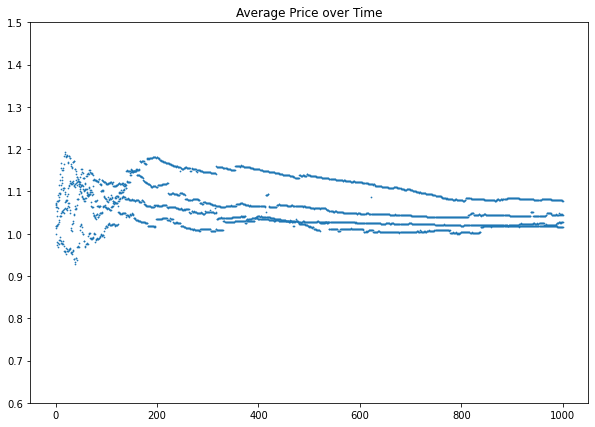

In [ ]:
plt.figure(figsize=(10,7))
plt.ylim(top=1.5, bottom=0.6)
plt.title("Average Price over Time")
plt.scatter(results_df["Step"], results_df["Average Price"], s=0.5)

In [ ]:
results_explore = results_df[results_df["vision_min"]==1]
results_explore = results_explore[results_explore["vision_max"]==8]
results_explore

,RunId,iteration,Step,width,height,vision_min,vision_max,Trader,Trade volume,Price,Average Price
1001,1,0,0,50,50,1,8,200,134,"[1.2050975673249005, 1.2012039685803861, 1.197...",1.013366
1002,1,0,1,50,50,1,8,200,178,"[1.2050975673249005, 1.2012039685803861, 1.197...",0.998183
1003,1,0,2,50,50,1,8,200,214,"[1.2050975673249005, 1.2012039685803861, 1.197...",0.981360
1004,1,0,3,50,50,1,8,200,244,"[1.2050975673249005, 1.2012039685803861, 1.197...",0.973399
1005,1,0,4,50,50,1,8,200,275,"[1.2050975673249005, 1.2012039685803861, 1.197...",0.969485
...,...,...,...,...,...,...,...,...,...,...,...
1997,1,0,996,50,50,1,8,42,763,"[0.9973823808990951, 1.0006510143047027, 1.034...",1.016849
1998,1,0,997,50,50,1,8,42,765,"[0.9973823808990951, 1.0006510143047027, 1.034...",1.016743
1999,1,0,998,50,50,1,8,42,767,"[0.9973823808990951, 1.0006510143047027, 1.034...",1.016563
2000,1,0,999,50,50,1,8,42,768,"[0.9973823808990951, 1.0006510143047027, 1.034...",1.016469


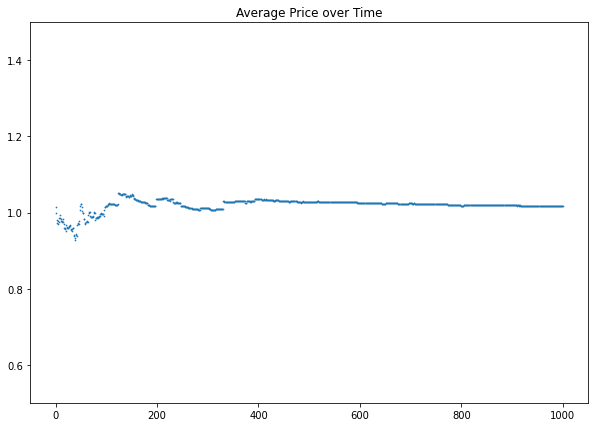

In [ ]:
plt.figure(figsize=(10,7))
plt.ylim(top=1.5, bottom=0.5)
plt.title("Average Price over Time")
plt.scatter(results_explore["Step"], results_explore["Average Price"], s=0.5)

 Bar Chart of all the trade volume takes too long so we will just look at the results explore. 

<BarContainer object of 1001 artists>

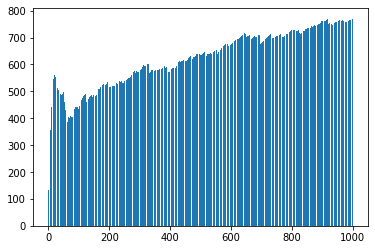

In [ ]:
plt.bar(results_explore["Step"],results_explore["Trade volume"])

## Results

**Part 2**

---------------------------------------------------------



In [ ]:
results = model.datacollector.get_model_vars_dataframe()

results

In [ ]:
#part 2

agent_results = model.datacollector.get_agent_vars_dataframe()


agent_results = agent_results[agent_results["Trade_Network"].notnull()]
agent_results

In [ ]:
results.plot(y = "Trader", use_index=True)

In [ ]:
# plot
#part 2a
results.plot(y = "Price", use_index=True)

In [ ]:
#part 2b
plt.bar(results.index, results["Trade volume"])

**Part 3**

---------------------------------------------------------------------

For the agent variable we will repsents a historgram of th enumber of trade 
partners of each agent. As you can see we get a heavy tailed distribution where most agents have a small number of trading partners but a small number of agents have a lot of trading partners. 

## Change to network!!!!

In [ ]:
network_hist = [len(trade) for  trade in list(agent_results["Trade_Network"])]

plt.hist(network_hist)
#

# Plot on a network

1st we need to do the graph

In [ ]:
G = nx.Graph()
#add agent keys to make initial node set
G.add_nodes_from(list(model.schedule.agents_by_type[Trader].keys()))
#create edge list
for key, value in agent_results.iterrows(): 
  #print(key, value)
  if len(value["Trade_Network"]) > 0: 
    for agent in value["Trade_Network"]:
      G.add_edge(key[1], agent)


In [ ]:
nx.node_connectivity(G), nx.average_clustering(G), nx.diameter(G), nx.global_efficiency(G)

(1, 0.35813629623908155, 8, 0.3871267109961739)

<BarContainer object of 31 artists>

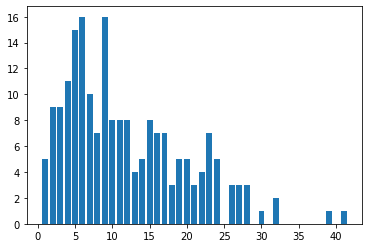

In [ ]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.bar(*np.unique(degree_sequence, return_counts=True))

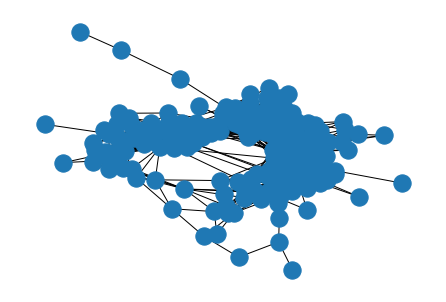

In [ ]:
nx.draw(G)